In [ ]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

In [ ]:
liked=pd.read_csv("usMerged.csv")
disliked=pd.read_csv("not100.csv")

In [ ]:
# IMPORT PACKAGES
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, matthews_corrcoef)
from sklearn.utils import resample

liked['TARGET'] = 1
disliked['TARGET'] = 0

# COMBINE top 100 and not 100 PLAYLIST
combined = pd.concat([liked,disliked], ignore_index=True)

In [ ]:
print('Liked Count:', len(liked))
print('Disliked Count:', len(disliked))

In [ ]:
# UPSAMPLING MINORITY CLASS (DISLIKED)

# SEPARATE MAJORITY AND MINORITY CLASSES
df_majority = combined[combined.TARGET==1]
df_minority = combined[combined.TARGET==0]
 
# UPSAMPLE MINORITY CLASS
df_minority_up = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=892,    # to match majority class
                                 random_state=123) # reproducible results
 
# COMBINED MAJORITY CLASS WITH UPSAMPLED MINORITY CLASS
df_upsampled = pd.concat([df_majority, df_minority_up])
 
# Display new class counts
df_upsampled.TARGET.value_counts()

In [6]:
df_upsampled

,track_name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,playlist_id,first_artist,date_added,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Rolling in the Deep,Adele,0.729,0.7560,8,-5.119,1,0.0294,0.1310,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Party Rock Anthem,LMFAO,0.750,0.7270,5,-4.210,0,0.1420,0.0189,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Firework,Katy Perry,0.638,0.8320,8,-5.039,1,0.0490,0.1410,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E.T.,Katy Perry,0.602,0.8630,5,-5.423,0,0.0773,0.0178,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Give Me Everything (feat. Ne-Yo, Afrojack & Na...",Pitbull,0.672,0.9340,3,-3.206,1,0.1550,0.1610,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,Electric Feel,NaN,0.763,0.8070,1,-3.714,1,0.0350,0.0714,0.280000,...,21s75xxd4pIfMQKpzfuGMJ,MGMT,2017-07-19T05:08:24Z,audio_features,3FtYbEfBqAlGO46NUDQSAt,spotify:track:3FtYbEfBqAlGO46NUDQSAt,https://api.spotify.com/v1/tracks/3FtYbEfBqAlG...,https://api.spotify.com/v1/audio-analysis/3FtY...,229640.0,3.0
1402,Sugarcane,NaN,0.361,0.0165,0,-27.874,1,0.0615,0.9950,0.967000,...,37i9dQZF1DX4sWSpwq3LiO,Ana Olgica,2020-04-20T15:20:39Z,audio_features,6uWjjaiquXsjuQuks2mZME,spotify:track:6uWjjaiquXsjuQuks2mZME,https://api.spotify.com/v1/tracks/6uWjjaiquXsj...,https://api.spotify.com/v1/audio-analysis/6uWj...,144500.0,3.0
1371,Confidante,NaN,0.395,0.0377,1,-27.013,1,0.0438,0.9950,0.952000,...,37i9dQZF1DX4sWSpwq3LiO,Eric Cadogan,2020-04-20T15:20:39Z,audio_features,2xnLBULgfS7IifhN40kRWZ,spotify:track:2xnLBULgfS7IifhN40kRWZ,https://api.spotify.com/v1/tracks/2xnLBULgfS7I...,https://api.spotify.com/v1/audio-analysis/2xnL...,127750.0,3.0
1359,Dreamland - Solo Piano Version,NaN,0.238,0.0848,3,-22.482,1,0.0357,0.9850,0.898000,...,37i9dQZF1DX4sWSpwq3LiO,Alexis Ffrench,2020-04-20T15:20:39Z,audio_features,7IOW37zJgduauyHWdihAnl,spotify:track:7IOW37zJgduauyHWdihAnl,https://api.spotify.com/v1/tracks/7IOW37zJgdua...,https://api.spotify.com/v1/audio-analysis/7IOW...,161258.0,3.0


In [7]:
from sklearn.feature_selection import SelectKBest

df_upsampled=df_upsampled.drop(['track_name', 'artist', 'duration_s', 'playlist_id', 'first_artist',
                               'date_added', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature'], axis=1)



In [8]:
features = SelectKBest(k=5)
features.fit(df_upsampled.loc[:, df_upsampled.columns != 'TARGET'], df_upsampled['TARGET'])

cols = list(df_upsampled.columns[features.get_support(1)])

In [9]:
cols

['danceability', 'energy', 'loudness', 'acousticness', 'instrumentalness']

In [10]:
# FEATURES & TARGET VARIABLE
features = df_upsampled[['energy','danceability','loudness','acousticness',
                        'instrumentalness']]
target = df_upsampled['TARGET']

In [11]:
# TRAINING / TESTING DATA
X_train, X_test, y_train, y_test = train_test_split(features, target)
print('Features Training Set:', X_train.shape, 'Features Testing Set:', X_test.shape)
print('Target Training Set:', y_train.shape, 'Target Testing Set:', y_test.shape)

Features Training Set: (1338, 5) Features Testing Set: (446, 5)
Target Training Set: (1338,) Target Testing Set: (446,)


In [12]:
# from sklearn.linear_model import LogisticRegression

# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)
# logreg_y_pred = logreg.predict(X_test)

In [13]:
# SETUP K-NN CLASSIFIER K=1
knn = KNeighborsClassifier(n_neighbors=2)

# FIT CLASSIFIER W/ K NEIGHBORS TO TRAINING DATA
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [14]:
test=pd.read_csv("japan_fin.csv")
test

,track_name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,class
0,Everyday、カチューシャ,AKB48,0.324,0.951,3,-4.531,1,0.1160,0.017800,0.000000,0.2120,0.230,172.455,312.307,1
1,フライングゲット,AKB48,0.515,0.948,0,-5.821,0,0.1210,0.056500,0.000003,0.3700,0.620,131.055,253.280,1
2,Born This Way,Lady Gaga,0.586,0.835,11,-5.117,1,0.1460,0.003820,0.000000,0.3030,0.493,123.935,260.413,1
3,桜の木になろう,AKB48,0.538,0.420,7,-9.546,1,0.0236,0.362000,0.000003,0.2600,0.358,79.976,329.893,1
4,マル・マル・モリ・モリ! (薫と友樹、たまにムック。) - インストロメンタル,スーパー☆キラキラ,0.595,0.395,4,-8.784,1,0.0327,0.386000,0.835000,0.1180,0.628,103.989,246.997,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,FAKE LOVE - Japanese ver.,BTS,0.577,0.746,2,-4.284,0,0.0386,0.002830,0.000000,0.2900,0.382,77.493,244.813,1
736,アゲイン,WANIMA,0.486,0.949,7,-2.397,1,0.0565,0.000272,0.000000,0.1880,0.358,97.268,214.088,1
737,Aurora,BUMP OF CHICKEN,0.535,0.851,10,-5.689,1,0.0463,0.005160,0.000000,0.0692,0.408,130.038,284.932,1
738,風を待つ,STU48,0.584,0.884,5,-2.602,1,0.0372,0.298000,0.000000,0.3450,0.620,120.001,227.373,1


In [15]:
test=test.drop(['track_name', 'artist', 'duration_s', 'key', 'mode', 'speechiness', 'liveness', 'valence', 'tempo', 'duration_s', 'class'], axis=1)
test

,danceability,energy,loudness,acousticness,instrumentalness
0,0.324,0.951,-4.531,0.017800,0.000000
1,0.515,0.948,-5.821,0.056500,0.000003
2,0.586,0.835,-5.117,0.003820,0.000000
3,0.538,0.420,-9.546,0.362000,0.000003
4,0.595,0.395,-8.784,0.386000,0.835000
...,...,...,...,...,...
735,0.577,0.746,-4.284,0.002830,0.000000
736,0.486,0.949,-2.397,0.000272,0.000000
737,0.535,0.851,-5.689,0.005160,0.000000
738,0.584,0.884,-2.602,0.298000,0.000000


In [16]:
test = resample(test, 
                                 replace=True,     # sample with replacement
                                 n_samples=446,    # to match majority class
                                 random_state=123) # reproducible results


In [17]:
test['pred']=knn.predict(test)


<ipython-input-17-5f9d170918a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred']=knn.predict(test)


In [141]:
test

,danceability,energy,loudness,acousticness,instrumentalness,pred
305,0.475,0.468,-6.123,0.16700,0.000000,1
500,0.594,0.935,-3.853,0.00221,0.000000,0
493,0.555,0.852,-3.761,0.55700,0.000000,1
186,0.358,0.915,-2.621,0.19900,0.000025,1
95,0.638,0.477,-9.505,0.19600,0.851000,0
...,...,...,...,...,...,...
194,0.673,0.883,-3.180,0.02750,0.000158,1
694,0.390,0.397,-9.963,0.28700,0.000000,0
501,0.547,0.824,-3.038,0.76900,0.000000,0
489,0.625,0.668,-4.315,0.28800,0.000000,0


In [105]:
y_pred

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,

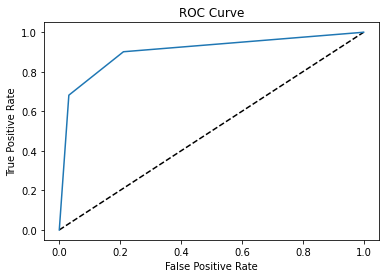

In [106]:
# ROC CURVE
y_pred_prob = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [107]:
# METRICS
print('Accuracy Score:', accuracy_score(y_test, y_pred))
y_pred_prob = knn.predict_proba(X_test)[:,1]
print('AUROC Score:',roc_auc_score(y_test, y_pred_prob))
print('MCC:', matthews_corrcoef(y_test, y_pred))
print('\n Clasification Report:\n', classification_report(y_test, y_pred))
cm =  confusion_matrix(y_test, y_pred)
print('\n Confusion Matrix:\n', cm)

Accuracy Score: 0.8251121076233184
AUROC Score: 0.9029741197289308
MCC: 0.6787791469412967

 Clasification Report:
               precision    recall  f1-score   support

           0       0.75      0.97      0.85       223
           1       0.96      0.68      0.80       223

    accuracy                           0.83       446
   macro avg       0.85      0.83      0.82       446
weighted avg       0.85      0.83      0.82       446


 Confusion Matrix:
 [[216   7]
 [ 71 152]]


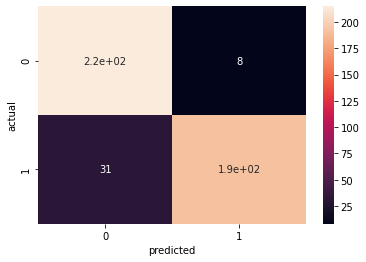

In [61]:
import seaborn as sn

con_matrix=pd.crosstab(y_test, y_pred, rownames=['actual'], colnames=['predicted'])
sn.heatmap(con_matrix, annot=True)